In [2]:
#%matplotlib inline
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
import pickle


from pygenstability import run, constructors, plotting
from pygenstability.contrib.optimal_scales import *

In [3]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[2] / "Software/Mobility Data Code/src")
if module_path not in sys.path:
    sys.path.append(module_path)

from partitioning import *

In [4]:
root_fig = '/home/tc/OneDrive/Software/Markov Stability Filtration/figures/'

# Generate multiscale SBM

In [5]:
from scipy.linalg import block_diag

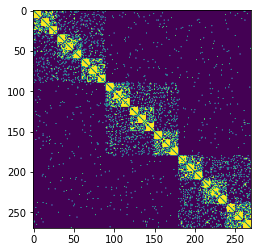

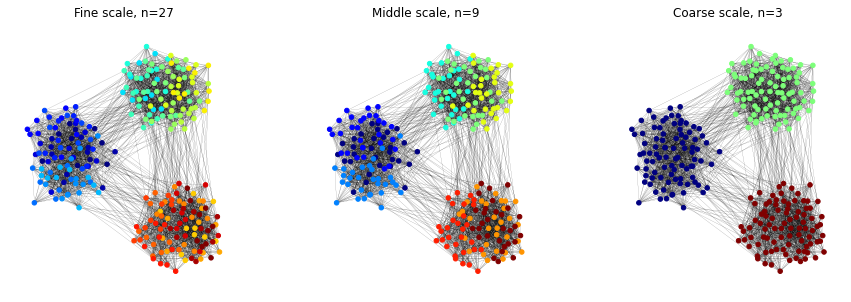

In [7]:
def block(n, th, rng):
    A = rng.uniform(0, 1, (n, n))
    A[A < th] = 0.0
    A[A > th] = 1.0
    A = (A + A.T) / 2
    return A


# define size and strength of multiscale structure
n0 = 270
th0 = 0.995

n1 = 3
th1 = 0.95

n2 = 9
th2 = 0.8

n3 = 27
th3 = 0.2

# construct adjacency matrix
rng = np.random.RandomState(42)
A = block(n0, th0, rng)
A += block_diag(*[block(int(n0 / n1), th1, rng) for i in range(n1)])
A += block_diag(*[block(int(n0 / n2), th2, rng) for i in range(n2)])
A += block_diag(*[block(int(n0 / n3), th3, rng) for i in range(n3)])

# binarized
A[A > 0] = 1

# remove self-loops
A -= np.diag(np.diag(A))

# plot matrix
plt.figure()
plt.imshow(A)
plt.savefig(root_fig +'adjacency_matrix.pdf', dpi=fig.dpi,bbox_inches='tight')

# Multiscale structure
coarse_scale_id = np.zeros(n0)
middle_scale_id = np.zeros(n0)
fine_scale_id = np.zeros(n0)

for i in range(n1):
    coarse_scale_id[(i * n0 // n1) : ((i + 1) * n0 // n1)] = i

for i in range(n2):
    middle_scale_id[(i * n0 // n2) : ((i + 1) * n0 // n2)] = i

for i in range(n3):
    fine_scale_id[(i * n0 // n3) : ((i + 1) * n0 // n3)] = i

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos_G = nx.layout.spring_layout(G, seed=1)

# Plot multiscale graph structure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

nx.draw(
    G,
    ax=axes[0],
    pos=pos_G,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=fine_scale_id,
    cmap="jet",
)
axes[0].set(title=r"Fine scale, n=27")

nx.draw(
    G,
    ax=axes[1],
    pos=pos_G,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=middle_scale_id,
    cmap="jet",
)
axes[1].set(title=r"Middle scale, n=9")

nx.draw(
    G,
    ax=axes[2],
    pos=pos_G,
    node_size=20,
    arrows=False,
    width=0.1,
    node_color=coarse_scale_id,
    cmap="jet",
)
axes[2].set(title=r"Coarse scale, n=3")

plt.savefig(root_fig +'Multiscale_Structure.pdf', dpi=fig.dpi,bbox_inches='tight')

# Markov Stability analysis on SBM model


In [8]:
graph = G
pos = pos_G
adj = A


In [9]:
# Set parameters
n_time = 200
min_time = -1.5
max_time = 0.5

In [10]:
all_results = run(adj, constructor='continuous_normalized', 
min_time=min_time,max_time=max_time,n_time=n_time)

100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


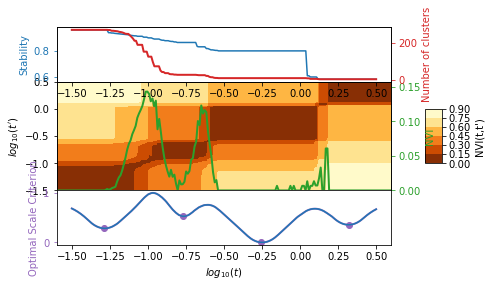

In [11]:
plotting.plot_scan(all_results, use_plotly=False)
plt.savefig(root_fig +'MS_Scan.pdf', dpi=fig.dpi,bbox_inches='tight')

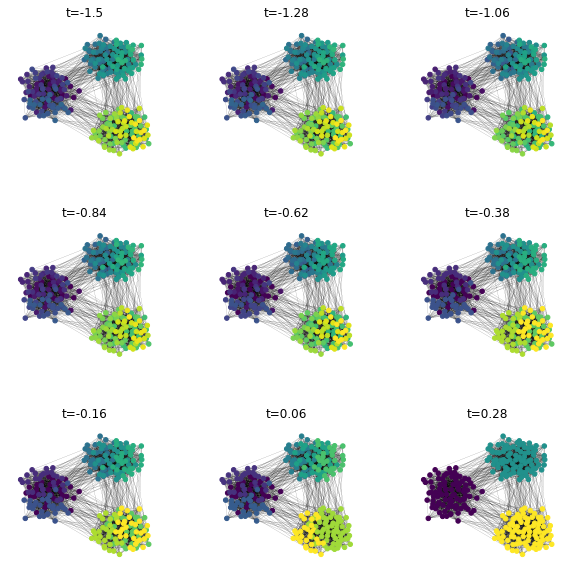

In [12]:
# Get times
times = all_results['times']
log_times = np.log10(all_results['times'])

# Get information about communities
community_id = all_results['community_id']
n_communities  = all_results['number_of_communities']

fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = int(i*len(times)/9)
    
    nx.draw(graph, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time])
    ax.set(title=r't={}'.format(np.around(np.log10(times[time]),2)))
plt.show()

[-1.28894472 -0.75628141 -0.24371859  0.31909548]


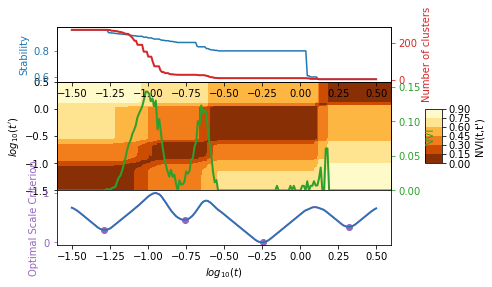

In [13]:
identify_optimal_scales(all_results,criterion_threshold=0.2,window_size=10)
selected_scales = log_times[all_results['selected_partitions']]
print(selected_scales)
plotting.plot_scan(all_results)
plt.savefig(root_fig +'MS_Scan.pdf',bbox_inches='tight')

In [14]:
selected_paritions = all_results['selected_partitions'][1:]

n_communities = [len(np.unique(all_results['community_id'][i])) for i in range(len(times))]

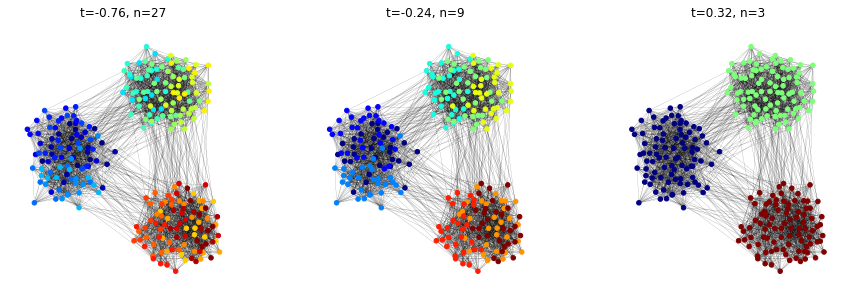

In [15]:
fig, axes = plt.subplots(1, len(selected_paritions), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = selected_paritions[i]
    
    nx.draw(graph, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(np.log10(times[time]),2), n_communities[time]))

plt.savefig(root_fig +'Partitions_ScaleCrit.pdf', dpi=fig.dpi,bbox_inches='tight')

# Markov Stability Filtration

Simplex Trees: 
- https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-simplex-Trees.ipynb
- https://gudhi.inria.fr/python/latest/simplex_tree_ref.html
- https://gudhi.inria.fr/python/latest/persistence_graphical_tools_ref.html

In [22]:
community_ids = all_results['community_id']

In [23]:
st = gd.SimplexTree()

As soon as the dimension of the simplices get too high (over 35), the kernel dies.

In [24]:
for i in range(len(log_times)):
    for c in node_id_to_dict(graph,community_ids[i]).values():

        # if len(c)<35:
        #     st.insert(list(c),filtration = log_times[i])


        # Only add small faces 
        for face in itertools.combinations(c, 4):
            st.insert(list(face),filtration = log_times[i])
        
       

In [25]:
st.dimension()

3

In [26]:
st.num_simplices()

8030295

# Persistant homology

In [27]:
persistence = st.persistence()#persistence_dim_max=True)

usetex mode requires dvipng.


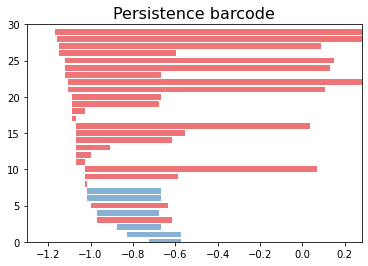

In [28]:
ax = gd.plot_persistence_barcode(persistence)
plt.show()

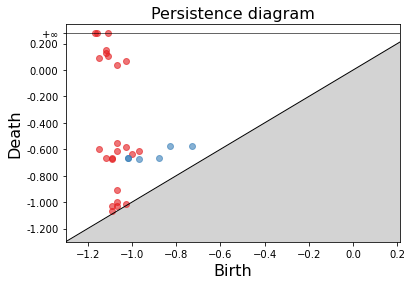

In [29]:
ax = gd.plot_persistence_diagram(persistence)
plt.show()
#plt.savefig(root_fig +'Persistence_diagram.pdf', dpi=fig.dpi,bbox_inches='tight')

In [30]:
# get set of deaths
deaths = np.asarray([persistence[i][1][1] for i in range(len(persistence))])

# drop duplicates
deaths = np.unique(deaths)

# replace inf with max time
deaths[deaths == np.inf] = log_times[-1]

# sort
deaths.sort()

In [31]:
# Compute differences to next death time
diff_deaths = deaths[1:] - deaths[:-1]
diff_deaths = np.append(diff_deaths,0)

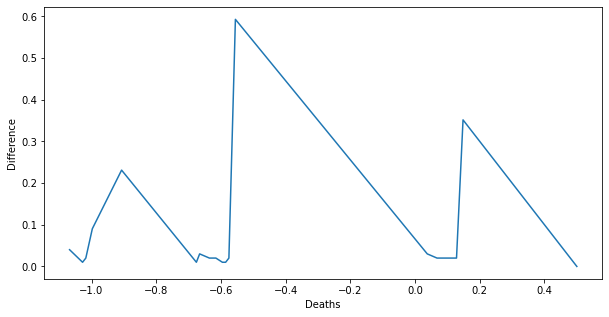

In [32]:
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(deaths,diff_deaths)
ax.set(xlabel='Deaths',ylabel='Difference')
plt.show()

In [33]:
from skimage.feature import peak_local_max

In [34]:
# Find local maxima
local_max_ind = peak_local_max(diff_deaths,threshold_abs=0.2).flatten()
local_max_ind.sort()

# Find indices of local max in log_times and of their succesors
left_gap = [np.argwhere(log_times == deaths[local_max_ind[i]]).flatten()[0] for i in range(len(local_max_ind))]
right_gap = [np.argwhere(log_times == deaths[local_max_ind[i]+1]).flatten()[0] for i in range(len(local_max_ind))]

# The optimal scales lie in the middle of the gaps
optimal_scales_ph = (np.array(left_gap)+np.array(right_gap))//2

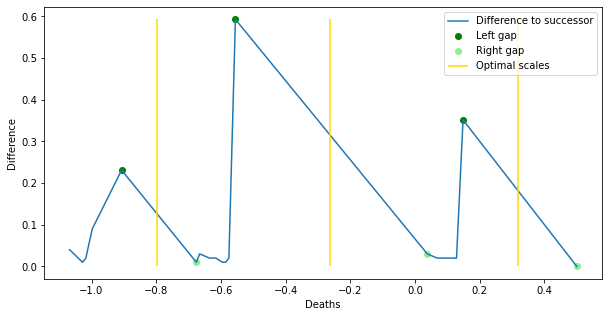

In [35]:
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(deaths,diff_deaths,label = 'Difference to successor')
ax.scatter(deaths[local_max_ind],diff_deaths[local_max_ind],color = 'green',label = 'Left gap')
ax.scatter(deaths[local_max_ind+1],diff_deaths[local_max_ind+1],color = 'lightgreen', label = 'Right gap')
ax.vlines(log_times[optimal_scales_ph],0,diff_deaths.max(),color='gold',label='Optimal scales')
ax.set(xlabel='Deaths',ylabel='Difference')
ax.legend()
plt.show()

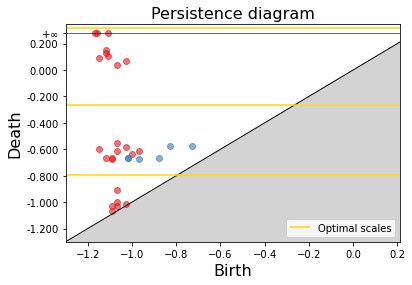

In [36]:
ax = gd.plot_persistence_diagram(persistence)
ax.hlines(log_times[optimal_scales_ph],log_times[0],log_times[-1],color='gold',label='Optimal scales')
ax.legend()
plt.savefig(root_fig +'Persistence_diagram.pdf', dpi=fig.dpi,bbox_inches='tight')

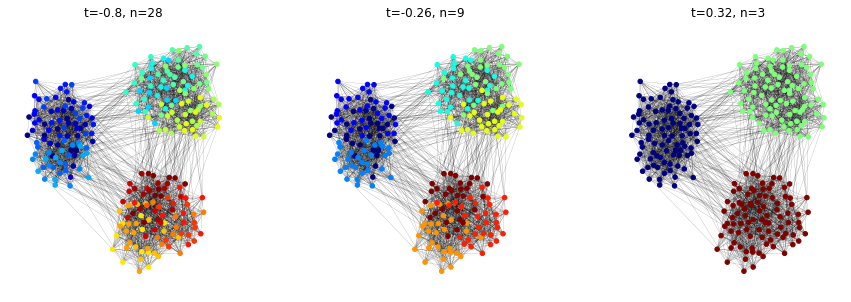

In [37]:
fig, axes = plt.subplots(1, len(optimal_scales_ph), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = optimal_scales_ph[i] 
    
    nx.draw(graph, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(np.log10(times[time]),2), n_communities[time]))

plt.savefig(root_fig +'Partitions_PH.pdf', dpi=fig.dpi,bbox_inches='tight')

# Derive function for PH worflow

In [39]:
results = all_results
max_dim = 4

In [ ]:
# get community assignments
community_ids = results['community_id']

# initialise simplex tree
st = gd.SimplexTree()

# add communities at scale t as simplices to tree
for t in range(len(log_times)):
    for c in node_id_to_dict(graph,community_ids[t]).values():
        # only add simplices of dimension smaller than max_dim
        for face in itertools.combinations(c, max_dim):
            st.insert(list(face),filtration = log_times[t])

# compute persitent homology
persistence = st.persistence()
        
       

# Other approaches

### Approach over derivatives

In [ ]:
# First death index
first_death_ind = np.argwhere(log_times == deaths[0]).flatten()[0]
# Interpolate diff_deaths
diff_deaths_interp = np.interp(log_times[first_death_ind:],deaths,diff_deaths)
# Compute derivates
second_derivative = abs(np.gradient(np.gradient(diff_deaths_interp)))

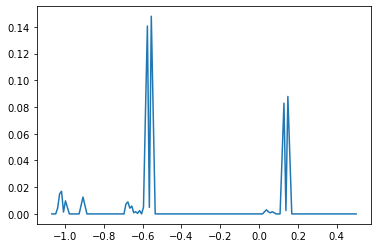

In [ ]:
#plt.scatter(log_times,np.interp(log_times,deaths,diff_deaths))
plt.plot(log_times[first_death_ind:],second_derivative )

### Manual approach

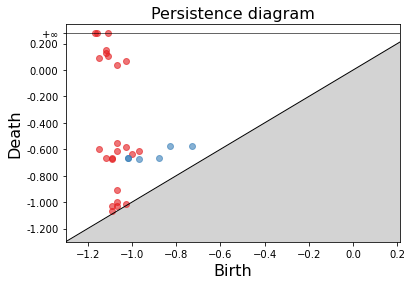

In [ ]:
ax = gd.plot_persistence_diagram(persistence)
plt.show()

In [ ]:
persistence

[(1, (-1.0175879396984926, -0.6658291457286432)),
 (1, (-1.0175879396984926, -0.6658291457286432)),
 (1, (-0.9673366834170855, -0.6758793969849246)),
 (1, (-0.8266331658291457, -0.5753768844221105)),
 (1, (-0.8768844221105527, -0.6658291457286432)),
 (1, (-0.7261306532663316, -0.5753768844221105)),
 (0, (-1.108040201005025, inf)),
 (0, (-1.1683417085427137, inf)),
 (0, (-1.1582914572864322, inf)),
 (0, (-1.1180904522613067, 0.14824120603015079)),
 (0, (-1.1180904522613067, 0.12814070351758786)),
 (0, (-1.1482412060301508, 0.08793969849246232)),
 (0, (-1.108040201005025, 0.10804020100502523)),
 (0, (-1.0678391959798996, 0.03768844221105524)),
 (0, (-1.0276381909547738, 0.0678391959798996)),
 (0, (-1.1482412060301508, -0.5954773869346733)),
 (0, (-1.0678391959798996, -0.5552763819095478)),
 (0, (-1.0678391959798996, -0.6155778894472361)),
 (0, (-1.1180904522613067, -0.6658291457286432)),
 (0, (-1.0276381909547738, -0.585427135678392)),
 (0, (-1.0879396984924623, -0.6658291457286432)),
 (

In [ ]:
selected_scales_ph = [-0.7864321608040201,-0.34422110552763807, 0.14824120603015079]
selected_partitions_ph = [np.argwhere(log_times == selected_scales_ph[i]).flatten()[0] for i in range(len(selected_scales_ph))]

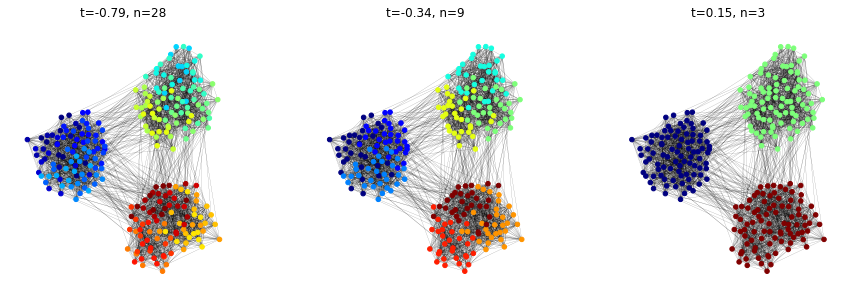

In [ ]:
fig, axes = plt.subplots(1, len(selected_partitions_ph), figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = selected_partitions_ph[i] 
    
    nx.draw(graph, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time],cmap = 'jet')
    ax.set(title=r't={}, n={}'.format(np.around(np.log10(times[time]),2), n_communities[time]))

#plt.savefig(root_fig +'Partitions_PH.pdf', dpi=fig.dpi,bbox_inches='tight')